In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the pandas library, used for data manipulation and analysis
import pandas as pd

# Importing numpy for numerical computations and operations
import numpy as np

# Importing IsolationForest for anomaly detection in high-dimensional datasets
from sklearn.ensemble import IsolationForest

# Importing OneClassSVM for one-class support vector machine anomaly detection
from sklearn.svm import OneClassSVM

# Importing matplotlib.pyplot for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt

# Importing DateFormatter to format datetime objects in matplotlib plots
from matplotlib.dates import DateFormatter

# Importing uniform_filter1d from scipy.ndimage for smoothing time series data
from scipy.ndimage import uniform_filter1d

# Importing seaborn for enhanced data visualization aesthetics
import seaborn as sns

# Importing adfuller for performing the Augmented Dickey-Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller

# Importing ARIMA for building Auto-Regressive Integrated Moving Average models
from statsmodels.tsa.arima.model import ARIMA

# Importing SARIMAX for building Seasonal Auto-Regressive Integrated Moving Average models with eXogenous regressors
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing mean_squared_error and mean_absolute_error for evaluating prediction accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Defining the path to the CSV file containing the dataset
file_path = '3810902.csv'

# Reading the dataset into a DataFrame using pandas
data = pd.read_csv(file_path)

# Displaying metadata about the DataFrame such as column types and counts
print("Data Info:")
print(data.info())

# Displaying the first few rows of the dataset for a quick overview
print("\nFirst few rows of data:")
print(data.head())

# Converting the 'DATE' column to datetime format, handling any errors encountered
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')

# Filling missing values in the 'TAVG' column with the average of 'TMAX' and 'TMIN'
data['TAVG'] = data['TAVG'].fillna((data['TMAX'] + data['TMIN']) / 2)

# Dropping rows where all of 'PRCP', 'TMAX', and 'TMIN' columns are missing
data = data.dropna(subset=['PRCP', 'TMAX', 'TMIN'], how='all')

# Displaying the count of missing values in each column after preprocessing
print("\nMissing values after preprocessing:")
print(data.isnull().sum())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16782 entries, 0 to 16781
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  16782 non-null  object 
 1   NAME     16782 non-null  object 
 2   DATE     16782 non-null  object 
 3   PRCP     15364 non-null  float64
 4   SNWD     2038 non-null   float64
 5   TAVG     5461 non-null   float64
 6   TMAX     15248 non-null  float64
 7   TMIN     14167 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.0+ MB
None

First few rows of data:
       STATION             NAME        DATE  PRCP  SNWD  TAVG  TMAX  TMIN
0  UKE00105860  NEWTON RIGG, UK  2024-01-01  0.44   NaN   NaN   NaN   NaN
1  UKE00105860  NEWTON RIGG, UK  2024-01-02  0.53   NaN   NaN   NaN   NaN
2  UKE00105860  NEWTON RIGG, UK  2024-01-03  0.04   NaN   NaN   NaN   NaN
3  UKE00105860  NEWTON RIGG, UK  2024-01-04  0.03   NaN   NaN   NaN   NaN
4  UKE00105860  NEWTON RIGG, UK  2024-01-05  0.03

In [3]:
# Printing a statistical summary of selected numerical columns
print("\nStatistical Summary:")

# Displaying descriptive statistics for 'PRCP', 'TAVG', 'TMAX', and 'TMIN' columns
# Includes metrics such as count, mean, std, min, max, and quartiles
print(data[['PRCP', 'TAVG', 'TMAX', 'TMIN']].describe())



Statistical Summary:
               PRCP          TAVG          TMAX          TMIN
count  15364.000000  15397.000000  15248.000000  14167.000000
mean       0.108536     49.527375     55.901626     43.001553
std        0.202152      7.954284      9.251606      7.936480
min        0.000000     22.000000     28.000000     12.000000
25%        0.000000     44.000000     49.000000     38.000000
50%        0.020000     49.500000     55.000000     44.000000
75%        0.130000     56.000000     62.000000     49.000000
max        3.460000     75.000000     91.000000     66.000000


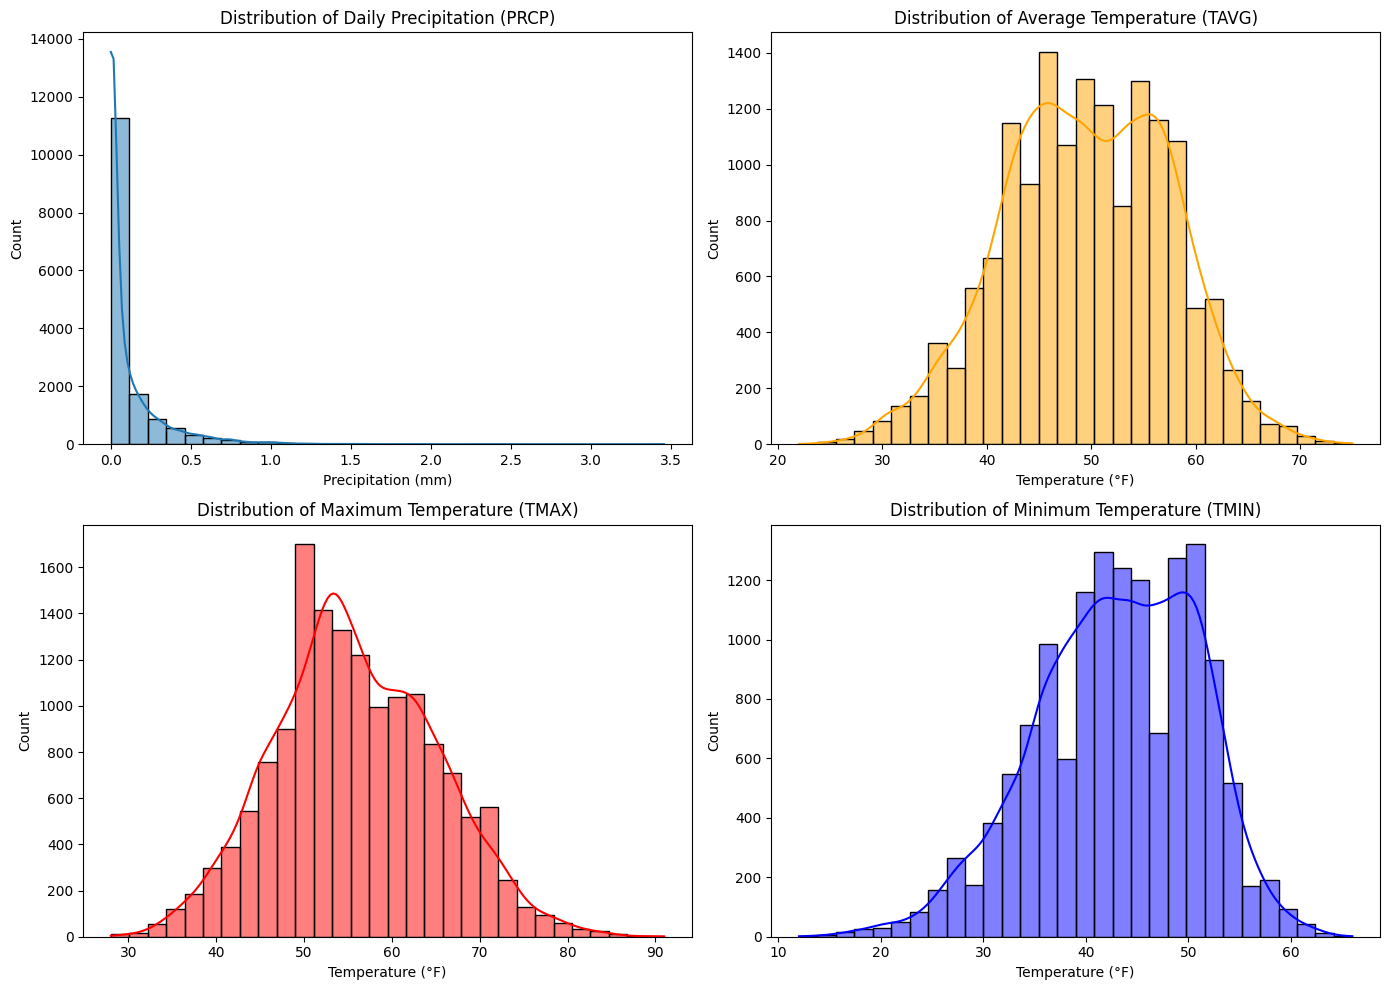

In [4]:
# Creating a figure to display multiple distribution plots in a single layout
plt.figure(figsize=(14, 10))

# Plotting the distribution of daily precipitation (PRCP)
plt.subplot(2, 2, 1)  # Setting the position for the first subplot
sns.histplot(data['PRCP'].dropna(), kde=True, bins=30)  # Plotting a histogram with kernel density estimate
plt.title('Distribution of Daily Precipitation (PRCP)')  # Adding a title to the plot
plt.xlabel('Precipitation (mm)')  # Labeling the x-axis

# Plotting the distribution of average temperature (TAVG)
plt.subplot(2, 2, 2)  # Setting the position for the second subplot
sns.histplot(data['TAVG'].dropna(), kde=True, bins=30, color='orange')  # Histogram with KDE in orange
plt.title('Distribution of Average Temperature (TAVG)')  # Adding a title to the plot
plt.xlabel('Temperature (°F)')  # Labeling the x-axis

# Plotting the distribution of maximum temperature (TMAX)
plt.subplot(2, 2, 3)  # Setting the position for the third subplot
sns.histplot(data['TMAX'].dropna(), kde=True, bins=30, color='red')  # Histogram with KDE in red
plt.title('Distribution of Maximum Temperature (TMAX)')  # Adding a title to the plot
plt.xlabel('Temperature (°F)')  # Labeling the x-axis

# Plotting the distribution of minimum temperature (TMIN)
plt.subplot(2, 2, 4)  # Setting the position for the fourth subplot
sns.histplot(data['TMIN'].dropna(), kde=True, bins=30, color='blue')  # Histogram with KDE in blue
plt.title('Distribution of Minimum Temperature (TMIN)')  # Adding a title to the plot
plt.xlabel('Temperature (°F)')  # Labeling the x-axis

# Adjusting the layout to prevent overlap between subplots
plt.tight_layout()

# Displaying the plot to the user
plt.show()


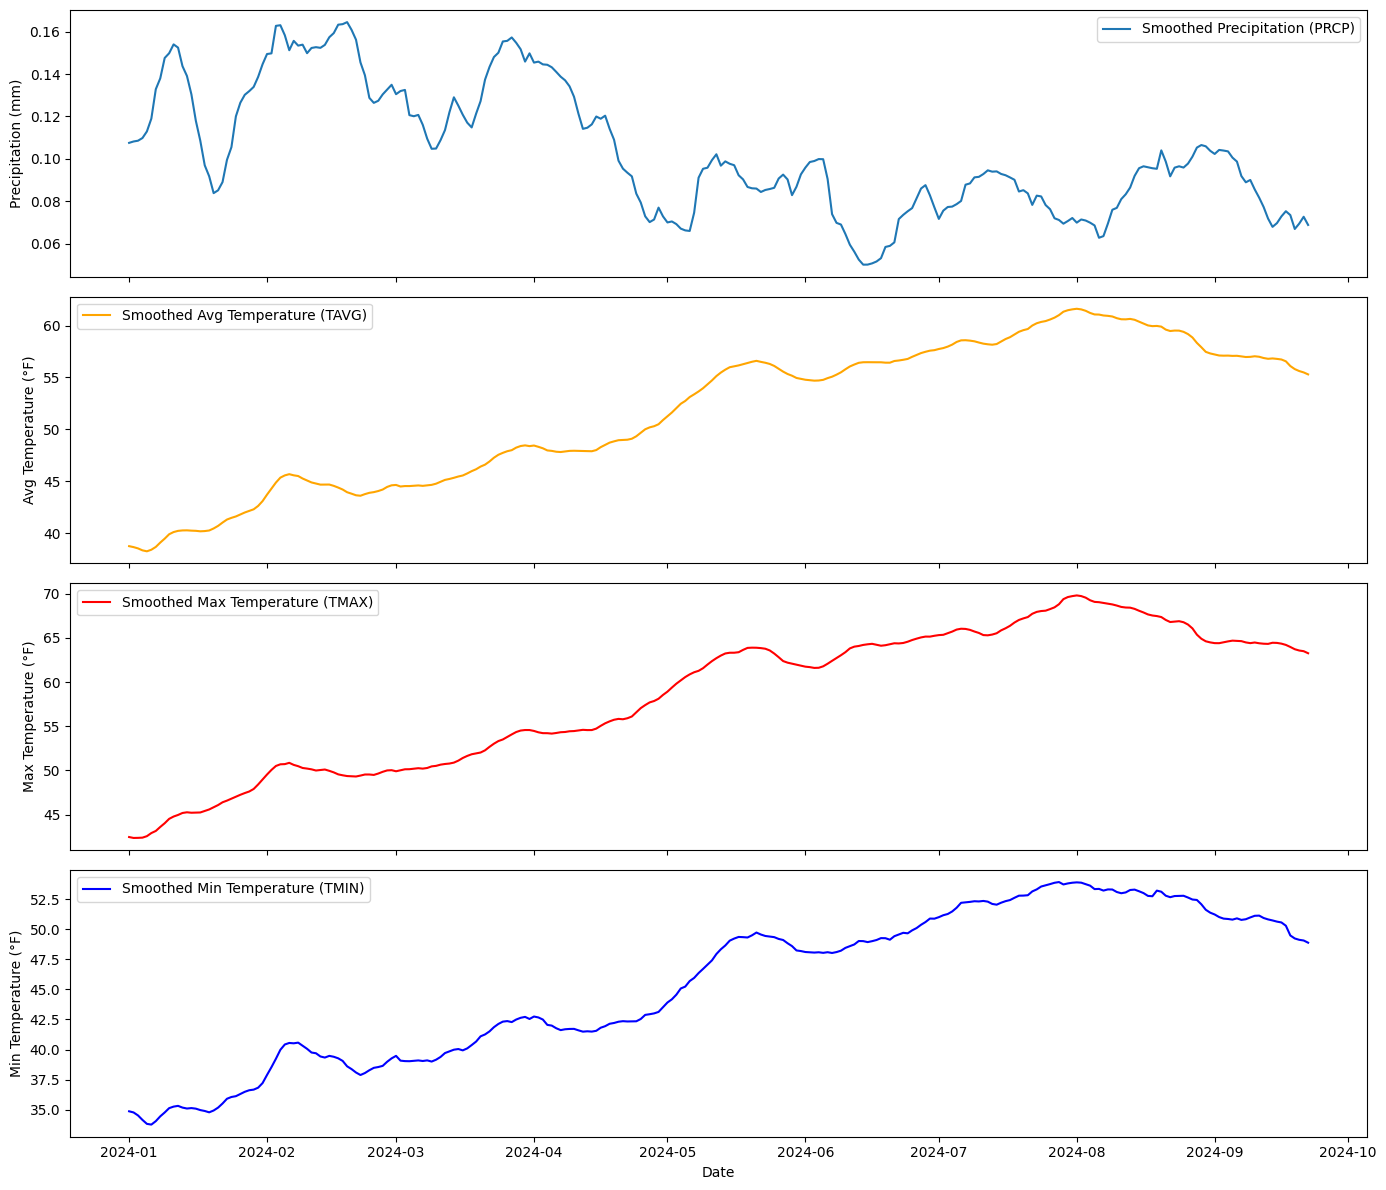

In [6]:
# Aggregate data by date (daily average of TAVG, TMAX, TMIN, and total PRCP)
aggregated_data = data.groupby('DATE').agg({
    'PRCP': 'mean',
    'TAVG': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean'
}).reset_index()

# Apply smoothing to the aggregated data
window_size = 30
smoothed_prcp = uniform_filter1d(aggregated_data['PRCP'].fillna(0), size=window_size)
smoothed_tavg = uniform_filter1d(aggregated_data['TAVG'].fillna(aggregated_data['TAVG'].mean()), size=window_size)
smoothed_tmax = uniform_filter1d(aggregated_data['TMAX'].fillna(aggregated_data['TMAX'].mean()), size=window_size)
smoothed_tmin = uniform_filter1d(aggregated_data['TMIN'].fillna(aggregated_data['TMIN'].mean()), size=window_size)

# Plotting smoothed trends without overlap
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Precipitation
axs[0].plot(aggregated_data['DATE'], smoothed_prcp, label='Smoothed Precipitation (PRCP)', linewidth=1.5)
axs[0].set_ylabel('Precipitation (mm)')
axs[0].legend()

# Average Temperature
axs[1].plot(aggregated_data['DATE'], smoothed_tavg, label='Smoothed Avg Temperature (TAVG)', color='orange', linewidth=1.5)
axs[1].set_ylabel('Avg Temperature (°F)')
axs[1].legend()

# Maximum Temperature
axs[2].plot(aggregated_data['DATE'], smoothed_tmax, label='Smoothed Max Temperature (TMAX)', color='red', linewidth=1.5)
axs[2].set_ylabel('Max Temperature (°F)')
axs[2].legend()

# Minimum Temperature
axs[3].plot(aggregated_data['DATE'], smoothed_tmin, label='Smoothed Min Temperature (TMIN)', color='blue', linewidth=1.5)
axs[3].set_ylabel('Min Temperature (°F)')
axs[3].legend()

axs[3].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [7]:
# Prepare data for models
model_data = aggregated_data[['DATE', 'PRCP', 'TAVG', 'TMAX', 'TMIN']].copy()

# Add smoothed data to the model_data DataFrame
model_data['Smoothed_PRCP'] = smoothed_prcp
model_data['Smoothed_TAVG'] = smoothed_tavg
model_data['Smoothed_TMAX'] = smoothed_tmax
model_data['Smoothed_TMIN'] = smoothed_tmin

# Drop any remaining missing values
model_data = model_data.dropna()

# Prepare features for anomaly detection
X = model_data[['Smoothed_PRCP', 'Smoothed_TAVG', 'Smoothed_TMAX', 'Smoothed_TMIN']].values

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest_preds = iso_forest.fit_predict(X)

# One-Class SVM
svm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
svm_preds = svm.fit_predict(X)

# Add anomaly labels to the model_data DataFrame
model_data['IsoForest_Anomaly'] = np.where(iso_forest_preds == -1, 1, 0)
model_data['OneClassSVM_Anomaly'] = np.where(svm_preds == -1, 1, 0)

# Print anomaly counts
print("\nAnomaly counts:")
print("Isolation Forest:", model_data['IsoForest_Anomaly'].sum())
print("One-Class SVM:", model_data['OneClassSVM_Anomaly'].sum())


Anomaly counts:
Isolation Forest: 14
One-Class SVM: 16


In [8]:
# Extreme weather thresholds
prcp_threshold = model_data['PRCP'].quantile(0.9)
tmax_threshold_high = model_data['TMAX'].quantile(0.95)
tmin_threshold_low = model_data['TMIN'].quantile(0.05)

# Flagging extreme events
model_data['Extreme_PRCP'] = model_data['PRCP'] > prcp_threshold
model_data['Extreme_TMAX'] = model_data['TMAX'] > tmax_threshold_high
model_data['Extreme_TMIN'] = model_data['TMIN'] < tmin_threshold_low

# Correlation with extreme weather
iso_extreme_prcp = model_data[model_data['IsoForest_Anomaly'] == 1]['Extreme_PRCP'].mean() * 100
iso_extreme_tmax = model_data[model_data['IsoForest_Anomaly'] == 1]['Extreme_TMAX'].mean() * 100
iso_extreme_tmin = model_data[model_data['IsoForest_Anomaly'] == 1]['Extreme_TMIN'].mean() * 100

svm_extreme_prcp = model_data[model_data['OneClassSVM_Anomaly'] == 1]['Extreme_PRCP'].mean() * 100
svm_extreme_tmax = model_data[model_data['OneClassSVM_Anomaly'] == 1]['Extreme_TMAX'].mean() * 100
svm_extreme_tmin = model_data[model_data['OneClassSVM_Anomaly'] == 1]['Extreme_TMIN'].mean() * 100

print("\nPercentage of anomalies linked to extreme weather conditions:")
print("Isolation Forest:", {'Extreme PRCP': iso_extreme_prcp, 'Extreme TMAX': iso_extreme_tmax, 'Extreme TMIN': iso_extreme_tmin})
print("One-Class SVM:", {'Extreme PRCP': svm_extreme_prcp, 'Extreme TMAX': svm_extreme_tmax, 'Extreme TMIN': svm_extreme_tmin})


Percentage of anomalies linked to extreme weather conditions:
Isolation Forest: {'Extreme PRCP': 35.714285714285715, 'Extreme TMAX': 7.142857142857142, 'Extreme TMIN': 28.57142857142857}
One-Class SVM: {'Extreme PRCP': 12.5, 'Extreme TMAX': 12.5, 'Extreme TMIN': 0.0}


In [9]:
# Refine model parameters
iso_forest_refined = IsolationForest(contamination=0.1, random_state=42)
iso_forest_refined_preds = iso_forest_refined.fit_predict(X)

svm_refined = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
svm_refined_preds = svm_refined.fit_predict(X)

# Add refined predictions to model_data
model_data['IsoForest_Anomaly_Refined'] = np.where(iso_forest_refined_preds == -1, 1, 0)
model_data['OneClassSVM_Anomaly_Refined'] = np.where(svm_refined_preds == -1, 1, 0)

# Re-calculate extreme correlations
iso_extreme_prcp_refined = model_data[model_data['IsoForest_Anomaly_Refined'] == 1]['Extreme_PRCP'].mean() * 100
iso_extreme_tmax_refined = model_data[model_data['IsoForest_Anomaly_Refined'] == 1]['Extreme_TMAX'].mean() * 100
iso_extreme_tmin_refined = model_data[model_data['IsoForest_Anomaly_Refined'] == 1]['Extreme_TMIN'].mean() * 100

svm_extreme_prcp_refined = model_data[model_data['OneClassSVM_Anomaly_Refined'] == 1]['Extreme_PRCP'].mean() * 100
svm_extreme_tmax_refined = model_data[model_data['OneClassSVM_Anomaly_Refined'] == 1]['Extreme_TMAX'].mean() * 100
svm_extreme_tmin_refined = model_data[model_data['OneClassSVM_Anomaly_Refined'] == 1]['Extreme_TMIN'].mean() * 100

# Display refined model results
print("\nRefined Model - Percentage of anomalies linked to extreme weather conditions:")
print("Isolation Forest Refined:", {
    'Extreme PRCP': iso_extreme_prcp_refined,
    'Extreme TMAX': iso_extreme_tmax_refined,
    'Extreme TMIN': iso_extreme_tmin_refined
})
print("One-Class SVM Refined:", {
    'Extreme PRCP': svm_extreme_prcp_refined,
    'Extreme TMAX': svm_extreme_tmax_refined,
    'Extreme TMIN': svm_extreme_tmin_refined
})


Refined Model - Percentage of anomalies linked to extreme weather conditions:
Isolation Forest Refined: {'Extreme PRCP': 22.22222222222222, 'Extreme TMAX': 14.814814814814813, 'Extreme TMIN': 25.925925925925924}
One-Class SVM Refined: {'Extreme PRCP': 10.714285714285714, 'Extreme TMAX': 14.285714285714285, 'Extreme TMIN': 7.142857142857142}


In [10]:
# Prepare Data for Time Series Analysis
newton_rigg_data = data[data['NAME'].str.contains("NEWTON RIGG", na=False)].copy()
newton_rigg_data['DATE'] = pd.to_datetime(newton_rigg_data['DATE'], errors='coerce')
newton_rigg_data = newton_rigg_data.set_index('DATE').sort_index()

# Perform Stationarity Test
prcp_data = newton_rigg_data['PRCP'].dropna().fillna(0)
adf_test = adfuller(prcp_data)
print(f"ADF Test Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

# Apply Differencing
prcp_diff = prcp_data.diff().dropna()
adf_test_diff = adfuller(prcp_diff)
print(f"ADF Test After Differencing: {adf_test_diff[0]}, p-value: {adf_test_diff[1]}")

# Split Data into Training and Testing Sets
train_size = int(len(prcp_diff) * 0.8)
train_data, test_data = prcp_diff[:train_size], prcp_diff[train_size:]

ADF Test Statistic: -2.6086353559131754, p-value: 0.09122561697100556
ADF Test After Differencing: -10.492911014969556, p-value: 1.1347900093165958e-18


C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-p

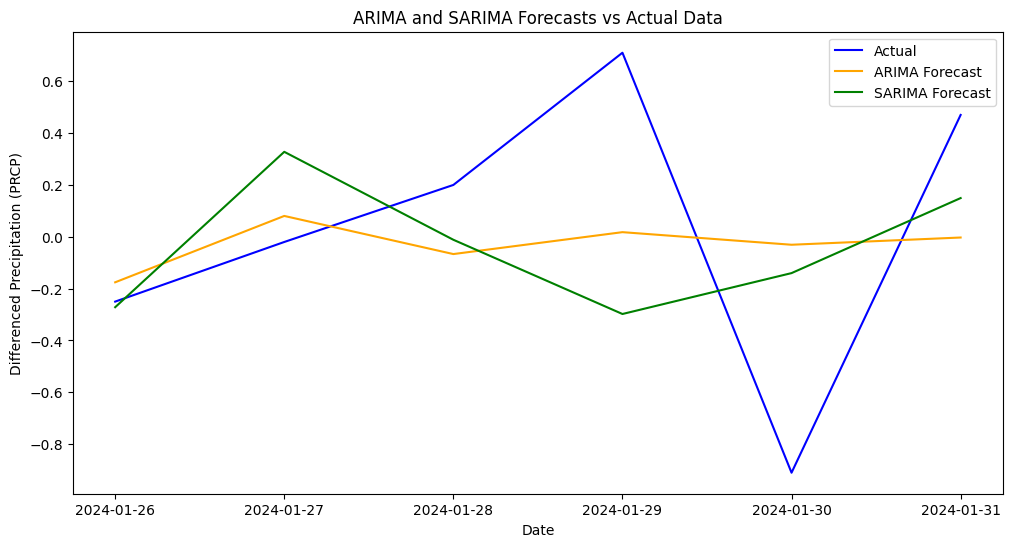

In [11]:
# Fit ARIMA Model
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_data))

# Fit SARIMA Model
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test_data))

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title('ARIMA and SARIMA Forecasts vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Differenced Precipitation (PRCP)')
plt.legend()
plt.show()

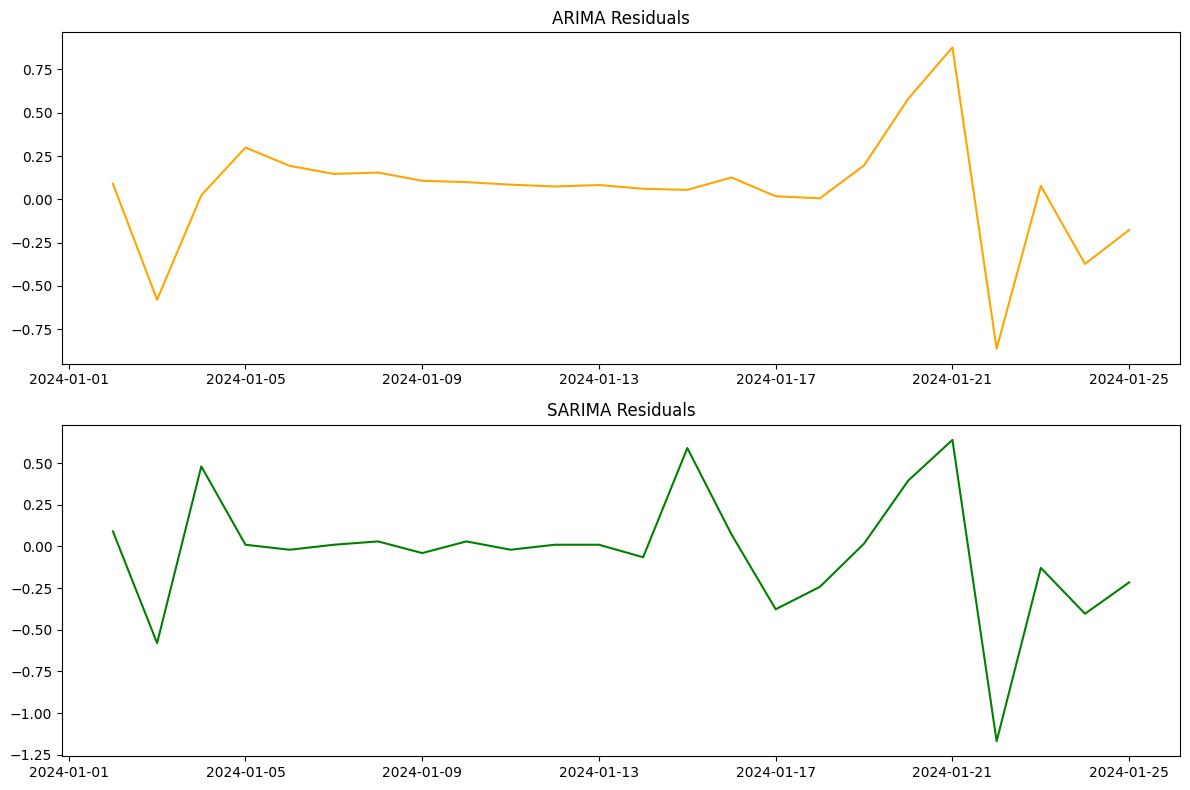

Error Metrics for ARIMA and SARIMA Models     Model      RMSE       MAE
0   ARIMA  0.510310  0.414296
1  SARIMA  0.559371  0.446528


In [12]:
# Residual Analysis
arima_residuals = arima_fit.resid
sarima_residuals = sarima_fit.resid

# Plot residuals
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(arima_residuals, label='ARIMA Residuals', color='orange')
axs[0].set_title("ARIMA Residuals")
axs[1].plot(sarima_residuals, label='SARIMA Residuals', color='green')
axs[1].set_title("SARIMA Residuals")
plt.tight_layout()
plt.show()

# Error Metrics
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast))
arima_mae = mean_absolute_error(test_data, arima_forecast)
sarima_mae = mean_absolute_error(test_data, sarima_forecast)

error_metrics = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA"],
    "RMSE": [arima_rmse, sarima_rmse],
    "MAE": [arima_mae, sarima_mae]
})

print("Error Metrics for ARIMA and SARIMA Models", error_metrics)

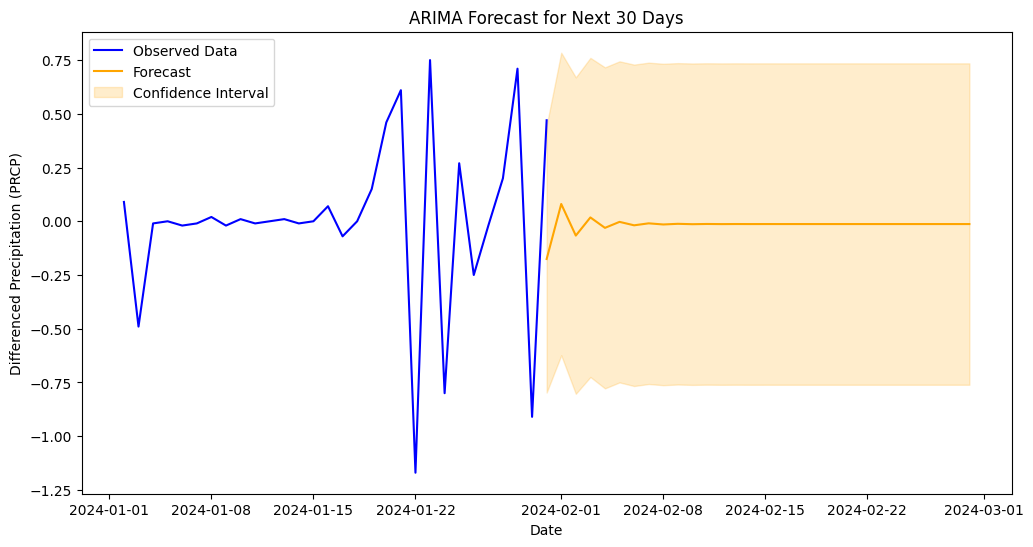

In [13]:
# Forecasting Future Data
future_forecast = arima_fit.get_forecast(steps=30)
future_index = pd.date_range(start=prcp_diff.index[-1], periods=30, freq='D')
future_forecast_mean = future_forecast.predicted_mean
future_forecast_ci = future_forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(prcp_diff.index, prcp_diff, label='Observed Data', color='blue')
plt.plot(future_index, future_forecast_mean, label='Forecast', color='orange')
plt.fill_between(future_index,
                 future_forecast_ci.iloc[:, 0],
                 future_forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Differenced Precipitation (PRCP)')
plt.legend()
plt.show()

C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


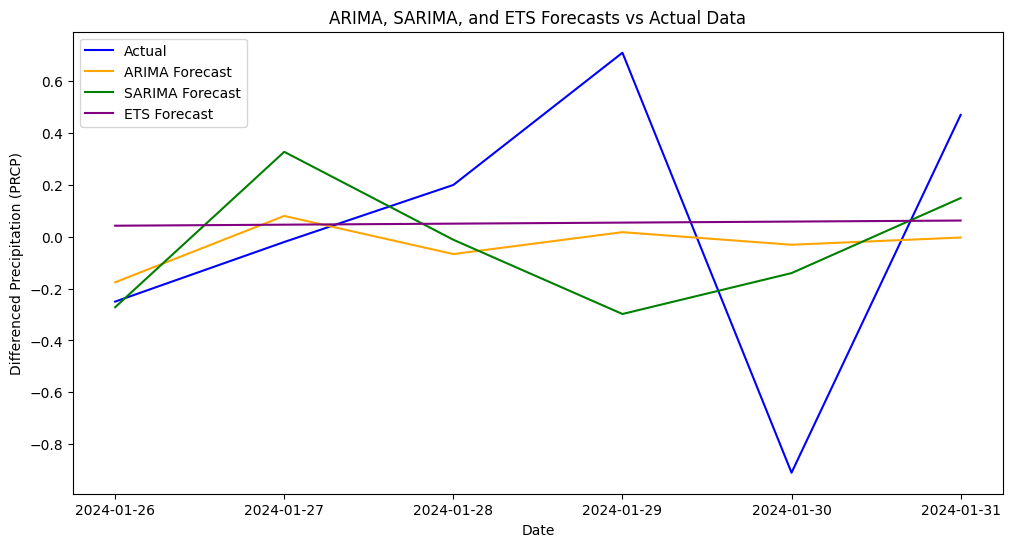

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing Model
ets_model = ExponentialSmoothing(
    train_data, 
    trend='add', 
    seasonal=None, 
    seasonal_periods=None
)
ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(steps=len(test_data))

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.plot(test_data.index, ets_forecast, label='ETS Forecast', color='purple')
plt.title('ARIMA, SARIMA, and ETS Forecasts vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Differenced Precipitation (PRCP)')
plt.legend()
plt.show()

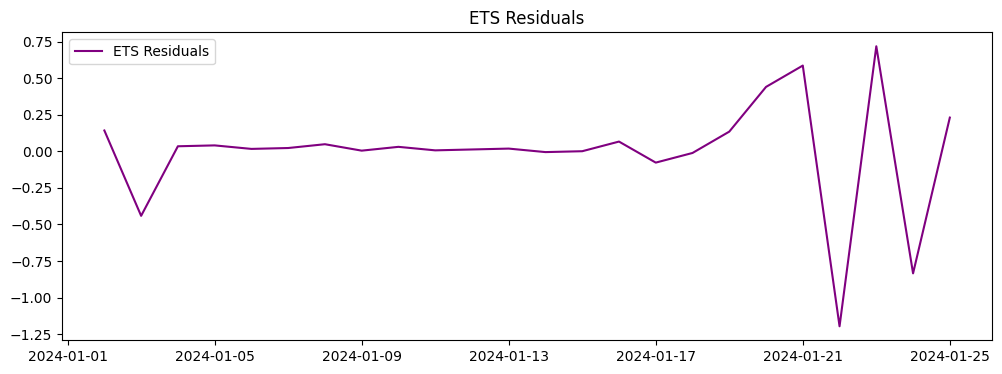

In [15]:
# Residual Analysis for ETS
ets_residuals = ets_fit.resid

# Plot ETS Residuals
plt.figure(figsize=(12, 4))
plt.plot(ets_residuals, label='ETS Residuals', color='purple')
plt.title("ETS Residuals")
plt.legend()
plt.show()

In [16]:
# Error Metrics
ets_rmse = np.sqrt(mean_squared_error(test_data, ets_forecast))
ets_mae = mean_absolute_error(test_data, ets_forecast)

# Print ETS-specific error metrics
print("Error Metrics for ETS Model:")
print(f"Root Mean Squared Error (RMSE): {ets_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {ets_mae:.4f}")

Error Metrics for ETS Model:
Root Mean Squared Error (RMSE): 0.5238
Mean Absolute Error (MAE): 0.4233
